# Algorytm Kirkpatricka

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from kirkpatrick_algorithm.visualizer.main import Visualizer
from scipy.spatial import Delaunay,delaunay_plot_2d
from planegeometry.structures.planarmaps import PlanarMap, Point, Segment, Triangle
from typing import List
import mapbox_earcut as earcut
from kirkpatrick_algorithm.kirkpatrick_point_location.point_location import Kirkpatrick

# Funkcje rysujące

In [2]:
def draw_polygon(polygon):
    vis = Visualizer()
    vis.add_point(polygon)
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [3]:
def draw_triangles(triangles: List[Triangle]):
    vis = Visualizer()
    for t in triangles:
        vis.add_polygon([(t.pt1.x, t.pt1.y), (t.pt2.x, t.pt2.y), (t.pt3.x, t.pt3.y)], fill=False, color="blue")
    
    vis.show()

In [4]:
def vis_add_triangle(vis: Visualizer, t: Triangle):
    vis.add_polygon([(t.pt1.x, t.pt1.y), (t.pt2.x, t.pt2.y), (t.pt3.x, t.pt3.y)], fill=False, color="blue")

In [5]:
def draw_planar_map(planar_map: PlanarMap, indepndent_set):
    vis = Visualizer()
    vis.add_line_segment([((segment.source.x, segment.source.y), (segment.target.x, segment.target.y)) for segment in planar_map.iteredges()])
    vis.add_point([(point.x, point.y) for point in planar_map.iterpoints()])
    vis.add_point([(point.x, point.y) for point in indepndent_set], color="red", zorder=10)
    vis.show()

In [6]:
def draw_triangulation_from_triangles(triangles : Delaunay):
    vis = Visualizer()
    for a, b, c in triangles.simplices:
        vis.add_polygon([triangles.points[a], triangles.points[b], triangles.points[c]], fill=False, color="red")
    vis.add_polygon(triangles.points, fill=False, color="blue")
    return vis

In [7]:
def add_triangulation_to_vis(vis: Visualizer, triangles : Delaunay):
    for a, b, c in triangles.simplices:
        vis.add_polygon([triangles.points[a], triangles.points[b], triangles.points[c]], fill=False)

In [8]:
def draw_triangulation_from_simplices(polygon, simplices):
    vis = Visualizer()
    for a, b, c in simplices:
        vis.add_polygon([polygon[a], polygon[b], polygon[c]], fill=False, color="red")
    vis.add_polygon(polygon, fill=False, color="blue")
    return vis

# Przykładowe wielokąty

In [9]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]

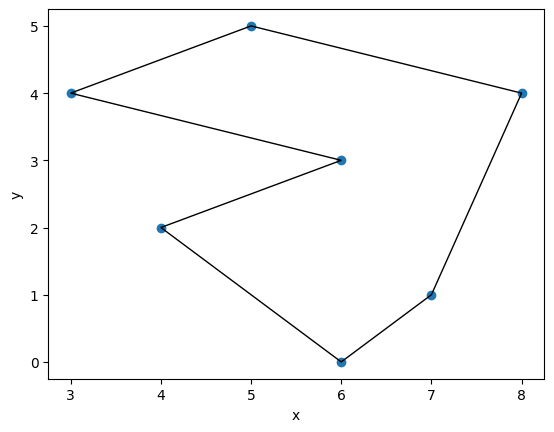

In [10]:
draw_polygon(polygon_example_1)

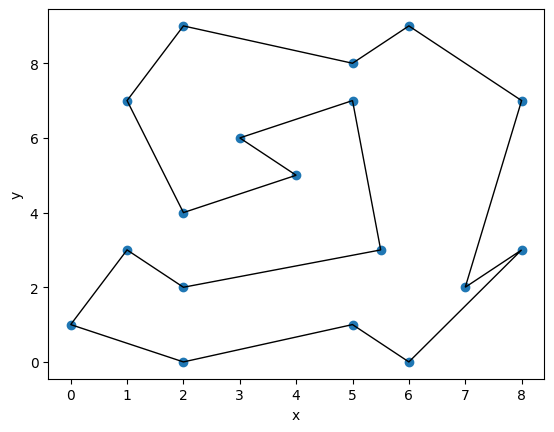

In [11]:
draw_polygon(polygon_example_2)

# Funkcja pozwalająca zadać wielokąt myszką

In [12]:
def get_polygon_points(max_x, max_y, points_data):
    %matplotlib tk
    fig = plt.figure()
    fig.set_label('Polygon Points')
    ax = fig.add_subplot(111)
    ax.set_title(f"Please select points for the polygon in counter-clockwise order")
    ax.set_xlim([0, max_x])
    ax.set_ylim([0, max_y])

    cid = None

    def onclick(event):
        plt.plot(event.xdata, event.ydata, 'bo')
        points_data.append((event.xdata, event.ydata))
        ax.annotate(f"{len(points_data)}", xy=(event.xdata, event.ydata))
        fig.canvas.draw()

    def on_close(event):
        fig.canvas.mpl_disconnect(cid)
        plt.close(fig)
        %matplotlib inline
        
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    cid = fig.canvas.mpl_connect('close_event', on_close)
    plt.show()

In [13]:
polygon = []
get_polygon_points(10, 10, polygon)

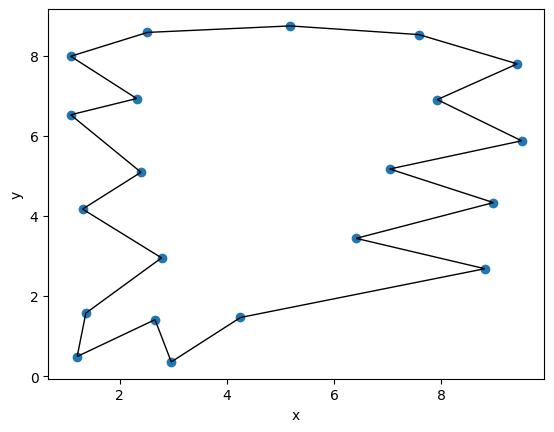

In [14]:
draw_polygon(polygon)

# Triangulacja wielokąta

## Triangulacja Delaunaya

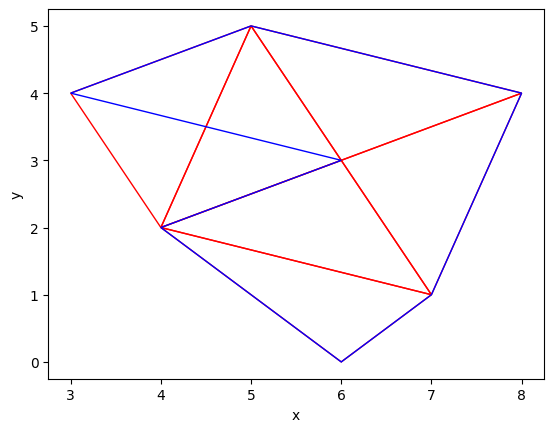

In [15]:
triangulation_delaunay_1 = Delaunay(polygon_example_1)
tri_vis_1 = draw_triangulation_from_triangles(triangulation_delaunay_1)
tri_vis_1.show()

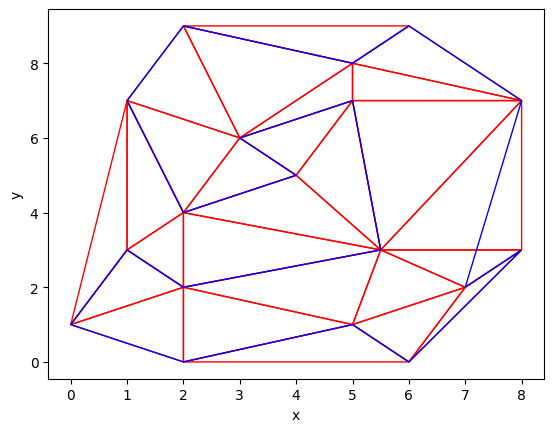

In [16]:
triangulation_delaunay_2 = Delaunay(polygon_example_2)
tri_vis_2 = draw_triangulation_from_triangles(triangulation_delaunay_2)
tri_vis_2.show()

## Triangulacja algorytmem earcut 

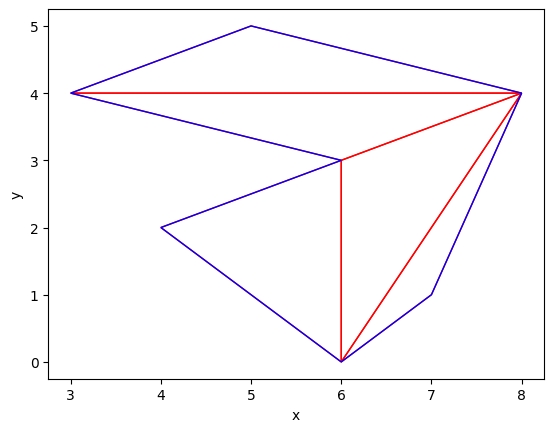

In [17]:
verts = np.array(polygon_example_1).reshape(-1, 2)
rings = np.array([len(polygon_example_1)])
result = earcut.triangulate_float64(verts, rings)

tri_vis_3 = draw_triangulation_from_simplices(polygon_example_1, result.reshape(-1, 3))
tri_vis_3.show()

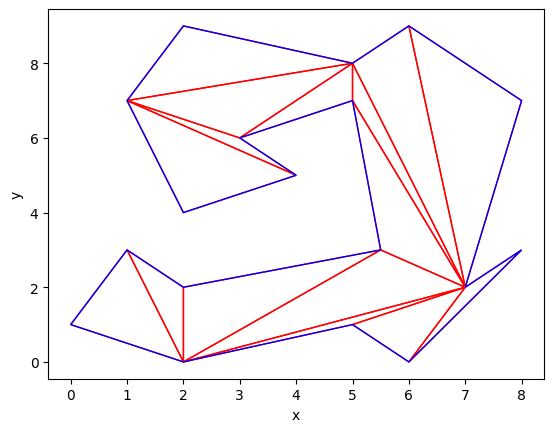

In [18]:
verts = np.array(polygon_example_2).reshape(-1, 2)
rings = np.array([len(polygon_example_2)])
result = earcut.triangulate_float64(verts, rings)

tri_vis_4 = draw_triangulation_from_simplices(polygon_example_2, result.reshape(-1, 3))
tri_vis_4.show()

# Dodawanie trójkąta zewnętrznego

In [19]:
def add_outer_triangle(polygon):
    min_x = min(polygon, key=lambda p: p[0])[0]
    max_x = max(polygon, key=lambda p: p[0])[0]
    min_y = min(polygon, key=lambda p: p[1])[1]
    max_y = max(polygon, key=lambda p: p[1])[1]

    a = (max_x - min_x)
    b = (max_y - min_y)

    min_x -= a*0.4
    max_x += a*0.4
    min_y -= b*0.4
    max_y += b*0.4

    a = (max_x - min_x)
    b = (max_y - min_y)

    sqrt_d = np.sqrt(4/3*b*b)

    d = (2*a + sqrt_d)/2

    shift = (d - a)/2
    H = d*np.sqrt(3)/2

    return [(max_x + shift, min_y),(min_x - shift, min_y), ((max_x - min_x)/2 + min_x, min_y + H)]


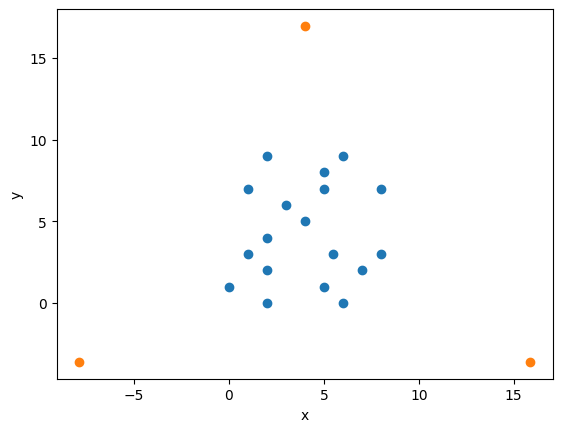

In [20]:
outer_triangle = add_outer_triangle(polygon_example_2)
vis = Visualizer()
vis.add_point(polygon_example_2)
vis.add_point(outer_triangle)
vis.show()

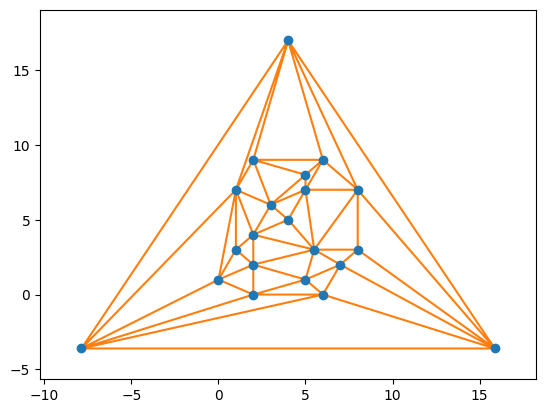

In [21]:
ex2_with_outer = polygon_example_2 + outer_triangle
tri_ex2 = Delaunay(ex2_with_outer)
_ = delaunay_plot_2d(tri_ex2)

In [22]:
outer_triangle=set([Point(x, y) for x, y in outer_triangle])

# Konwersja polygonu do formatu listy sąsiedztwa

In [23]:
def get_planar_map(delaunay: Delaunay) -> PlanarMap:
    set_of_edges = set()
    points = [Point(p[0], p[1]) for p in delaunay.points]

    get_edge = lambda a, b: (min(a, b), max(a, b))

    for a, b, c in delaunay.simplices:
        set_of_edges.add(get_edge(a, b))
        set_of_edges.add(get_edge(b, c))
        set_of_edges.add(get_edge(a, c))

    segments = [Segment(points[a], points[b]) for a, b in set_of_edges]

    dcel_map = PlanarMap(segments[0])
    for i in range(1, len(segments)):
        dcel_map.add_edge(segments[i])

    return dcel_map

In [24]:
planar_map = get_planar_map(tri_ex2)

In [25]:
def get_independent_set(planar_map: PlanarMap, outer_triangle):
    visited = set()
    independent_set = []

    for point in planar_map.iterpoints():
        if point not in visited and point not in outer_triangle:
            independent_set.append(point)
            
            for adjacent_point in planar_map.iteradjacent(point):
                visited.add(adjacent_point)

    return independent_set

In [26]:
indepndent_set = get_independent_set(planar_map, outer_triangle)

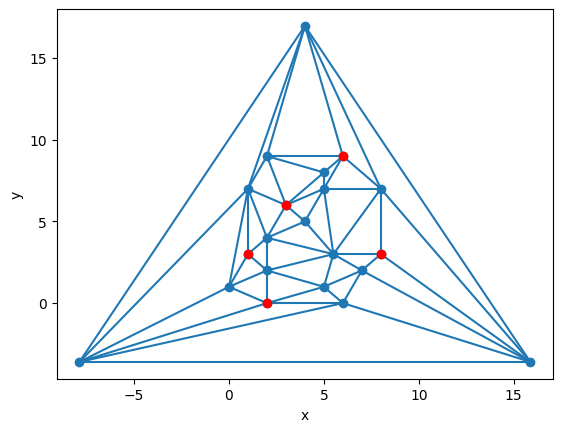

In [27]:
vis = Visualizer()
vis.add_line_segment([((segment.source.x, segment.source.y), (segment.target.x, segment.target.y)) for segment in planar_map.iteredges()])
vis.add_point([(point.x, point.y) for point in planar_map.iterpoints()])
vis.add_point([(point.x, point.y) for point in indepndent_set], color="red", zorder=10)
vis.show()

In [28]:
def remove_independent_set(planar_map: PlanarMap, indepndent_set, outer_triangle):
    holes = []
    removed_triangles = []
    deleted_nodes = 0

    for independent_point in indepndent_set:
        if independent_point not in outer_triangle:
            outedges = sorted(list(planar_map.iteroutedges(independent_point)), key=lambda e: (e.target - e.source).alpha())
            holes.append([outedge.target for outedge in outedges])
            removed_triangles.append([])
            for i in range(len(holes[-1])):
                removed_triangles[-1].append(Triangle(independent_point, holes[-1][i-1], holes[-1][i]))

            planar_map.del_node(independent_point)
            deleted_nodes += 1

    return holes, deleted_nodes, removed_triangles

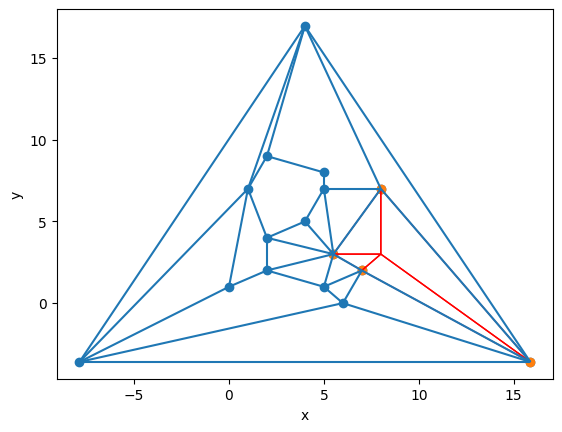

In [29]:
holes, deleted_points, removed_triangles = remove_independent_set(planar_map, indepndent_set, outer_triangle)
vis.clear()
vis.add_line_segment([((segment.source.x, segment.source.y), (segment.target.x, segment.target.y)) for segment in planar_map.iteredges()])
vis.add_point([(point.x, point.y) for point in planar_map.iterpoints()])
vis.add_point([(point.x, point.y) for point in holes[0]])
for t in removed_triangles[0]:
    vis.add_polygon([(t.pt1.x, t.pt1.y), (t.pt2.x, t.pt2.y), (t.pt3.x, t.pt3.y)], fill=False, color="red")
vis.show()

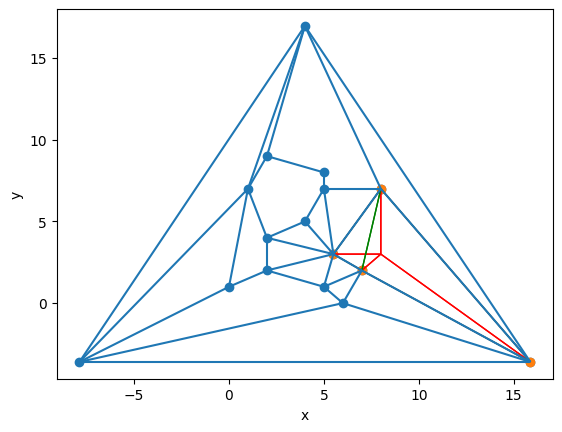

In [30]:
verts = np.array([[point.x, point.y] for point in holes[0]]).reshape(-1, 2)
rings = np.array([len(verts)])
result = earcut.triangulate_float64(verts, rings)
for a, b, c in result.reshape(-1,3):
    vis.add_polygon([verts[a], verts[b], verts[c]], fill=False, color="green")
vis.show()

# Algorytm Kirkpatricka

## Preprocessing wielokąta

In [31]:
def triangle_intersect(t1: Triangle, t2: Triangle):
    for t1_segment in t1.itersegments():
        for t2_segment in t2.itersegments():
            if t1_segment.intersect(t2_segment):
                return True
            
    return False

In [32]:
def kirkpatrick_preprocess(polygon: List[tuple[float, float]]):
    outer_triangle = add_outer_triangle(polygon)
    polygon_with_outer_triangle = polygon + outer_triangle

    delaunay_triangulation = Delaunay(polygon_with_outer_triangle)
    outer_triangle = set([Point(x, y) for x, y in outer_triangle])

    planar_map = get_planar_map(delaunay_triangulation)

    v = len(polygon_with_outer_triangle)

    triangles_graph = {}

    for a, b, c in delaunay_triangulation.simplices:
        triangle = Triangle(Point(polygon_with_outer_triangle[a][0], polygon_with_outer_triangle[a][1]),
                            Point(polygon_with_outer_triangle[b][0], polygon_with_outer_triangle[b][1]),
                            Point(polygon_with_outer_triangle[c][0], polygon_with_outer_triangle[c][1]))
        
        triangles_graph[triangle] = []


    while v > 3:
        independent_set = get_independent_set(planar_map, outer_triangle)
        holes_points, removed, all_removed_triangles = remove_independent_set(planar_map, independent_set, outer_triangle)

        v -= removed

        for hole_points, removed_triangles in zip(holes_points, all_removed_triangles):
            verts = np.array([[point.x, point.y] for point in hole_points]).reshape(-1, 2)
            rings = np.array([len(verts)])
            result = earcut.triangulate_float64(verts, rings)

            for a, b, c in result.reshape(-1,3):
                new_triangle = Triangle(hole_points[a], hole_points[b], hole_points[c])

                for segment in new_triangle.itersegments():
                    if not planar_map.has_edge(segment):
                        planar_map.add_edge(segment)

                if not new_triangle in triangles_graph:
                    triangles_graph[new_triangle] = []
                    
                for old_triangle in removed_triangles:
                    if triangle_intersect(new_triangle, old_triangle):
                        triangles_graph[new_triangle].append(old_triangle)
                

    outer_triangle = list(outer_triangle)
    return triangles_graph, Triangle(outer_triangle[0], outer_triangle[1], outer_triangle[2]), delaunay_triangulation

## Lokalizacja punktu

In [33]:
def locate(triangles_graph, root: Triangle, point: (float, float)):
    point = Point(point[0], point[1])

    if not point in root:
        return None
    
    current = root
    while triangles_graph[current]:
        for triangle in triangles_graph[current]:
            if point in triangle:
                current = triangle
                break

    return current

In [34]:
def draw_localisation(triangulation: Delaunay, point: (float, float), found_triangle: Triangle):
    vis = Visualizer()
    add_triangulation_to_vis(vis, triangulation)
    vis.add_point(point, zorder=10)
    t = found_triangle
    vis.add_polygon([(t.pt1.x, t.pt1.y), (t.pt2.x, t.pt2.y), (t.pt3.x, t.pt3.y)], color="yellow")
    vis.show()

## Test algorytmu Kirkpatricka

In [35]:
triangles_graph, root, delaunay_triangulation = kirkpatrick_preprocess(polygon_example_2)

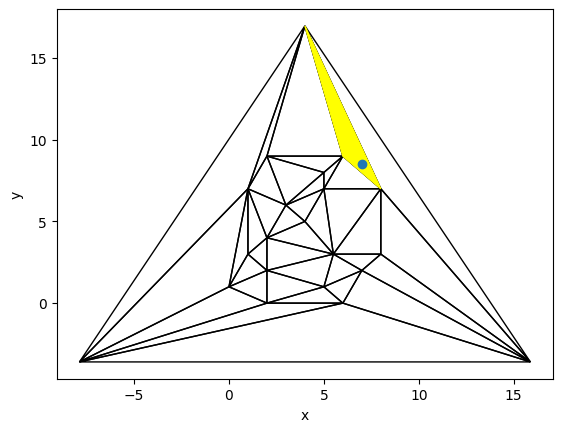

In [36]:
point_to_locate = (7,8.5)
found_triangle = locate(triangles_graph, root, point_to_locate)
draw_localisation(delaunay_triangulation, point_to_locate, found_triangle)

## Przykład wykorzystania przygotowanej biblioteki

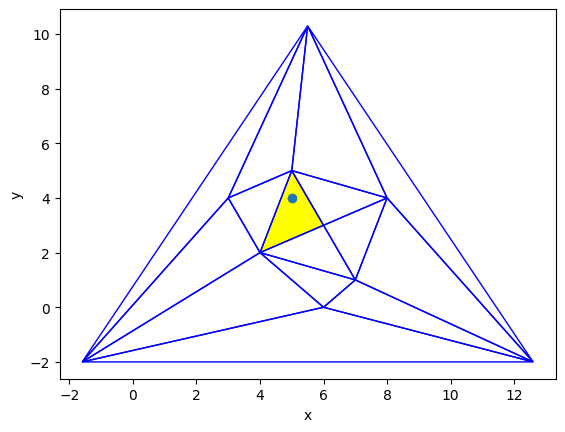

In [37]:
kirkpatrick = Kirkpatrick(polygon_example_1)
kirkpatrick.preprocess()
kirkpatrick.query_with_show((5, 4))

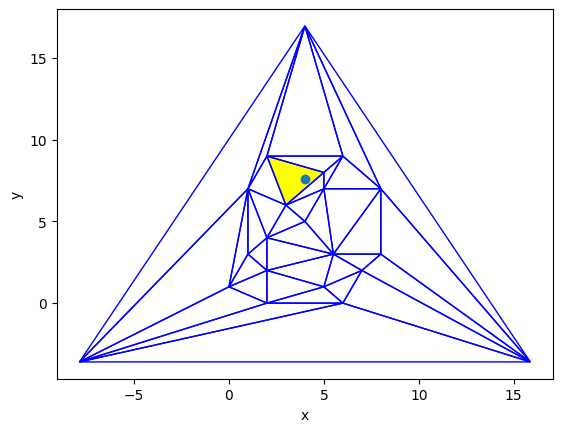

In [38]:
kirkpatrick = Kirkpatrick(polygon_example_2)
kirkpatrick.preprocess()
kirkpatrick.query_with_show((4, 7.6))

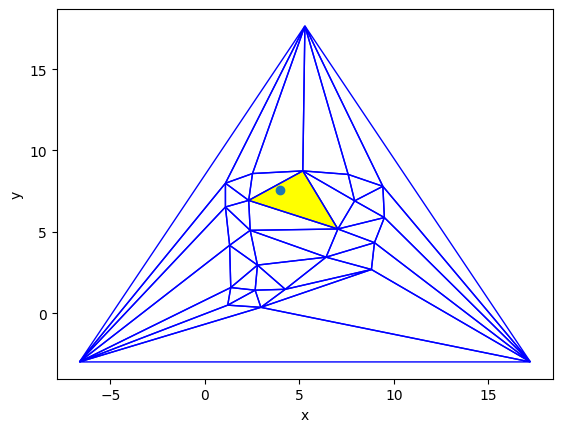

In [39]:
kirkpatrick = Kirkpatrick(polygon)
kirkpatrick.preprocess()
kirkpatrick.query_with_show((4, 7.6))

## Test korzystania z przygotowanej biblioteki do wizualizacji